In [ ]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from IPython.display import FileLink,display, Image
from PIL import Image as I

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files     
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from random import sample
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import numpy as np
import pandas as pd

from glob import glob
import pickle
import zipfile
import os
import cv2
import timeit
import time
import h5py

In [ ]:
# Create folder
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [ ]:
# check if CUDA is available
if tf.test.is_gpu_available(cuda_only=True):
     print('CUDA is available!  Training on GPU ...')

img_size = 244 if  tf.test.is_gpu_available(cuda_only=True) else 160
channel = 3
n_classes = 10
epochs = 50
batch_size = 50
test_size = 10

In [ ]:
pip install tensorflow

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [ ]:
df = pd.read_csv("C:/Users/Abhin/Downloads/state-farm-distracted-driver-detection/driver_imgs_list.csv")
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


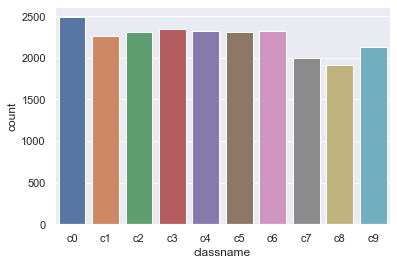

In [ ]:
sns.set()
ax = sns.countplot(x="classname", data=df)

In [ ]:
# Load the dataset 
def get_cv2_image(path, img_size, color_type):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # Loading as color image
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img[:500], (img_size, img_size)) 
    return img

In [ ]:
train_images = []
train_labels = []
def create_train_data(img_size , color_type):
    start_time = time.time()
    # Loop over the training folder 
    for class_ in range(n_classes):
        
        print('Loading directory c{}'.format(class_))
        
        files = glob(os.path.join('C:/Users/Abhin/Downloads/state-farm-distracted-driver-detection/imgs/train', 'c' + str(class_), '*.jpg'))
        
        for file in files:
            img = get_cv2_image(file, img_size , color_type)
            train_images.append(img)
            train_labels.append(class_) 
    
    print("Data Loaded in {} Min".format((time.time() - start_time)/60))
    return train_images, train_labels 

In [ ]:
X, y = create_train_data(img_size , channel)

Loading directory c0
Loading directory c1
Loading directory c2
Loading directory c3
Loading directory c4
Loading directory c5
Loading directory c6
Loading directory c7
Loading directory c8
Loading directory c9
Data Loaded in 1.332314133644104 Min


In [ ]:
#shape of input tensor
X[0].shape

(224, 224, 3)

In [ ]:
#converting labels to categorical 
y = np_utils.to_categorical(y, n_classes)
y[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# splitting train data to train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15,shuffle=True, random_state=2021)
print(X_train[0])

[[[ 35  44  31]
  [ 35  44  31]
  [ 35  44  31]
  ...
  [164 202 175]
  [ 81 103  91]
  [ 20  26  26]]

 [[ 35  44  31]
  [ 35  44  31]
  [ 35  44  31]
  ...
  [227 254 228]
  [235 252 237]
  [220 222 218]]

 [[ 35  44  31]
  [ 35  44  31]
  [ 35  44  31]
  ...
  [234 251 219]
  [245 252 231]
  [254 251 239]]

 ...

 [[  5   7   7]
  [  5   7   7]
  [  5   7   7]
  ...
  [  8   9  13]
  [  8   9  13]
  [  9  10  14]]

 [[  5   7   7]
  [  5   7   7]
  [  5   7   7]
  ...
  [  7   8  12]
  [  8   9  13]
  [  9  10  14]]

 [[  5   7   7]
  [  5   7   7]
  [  5   7   7]
  ...
  [  6   7  11]
  [  7   8  12]
  [  8   9  13]]]


In [ ]:
# convert data to numpy array for training
X_train = np.array(X_train, dtype=np.uint8).reshape(-1,img_size,img_size,channel)
X_valid = np.array(X_valid, dtype=np.uint8).reshape(-1,img_size,img_size,channel)

print('Train shape :', X_train.shape)
print('Number of train samples : ',X_train.shape[0])

print('Validation shape :', X_valid.shape)
print('Number of Validation samples : ',X_valid.shape[0])

Train shape : (19060, 224, 224, 3)
Number of train samples :  19060
Validation shape : (3364, 224, 224, 3)
Number of Validation samples :  3364


In [ ]:
random.shuffle(X_train)

In [ ]:
def load_testing_data(test_size,img_size,color_type):

    files = sorted(glob(os.path.join('C:/Users/Abhin/Downloads/state-farm-distracted-driver-detection/imgs/test', '*.jpg')))
    test_image = []
    test_image_label = []
    
    total = 0
    files_size = len(files)
    
    for file in files:
        
        if total == test_size:
            break
            
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_size, color_type)
        test_image.append(img)
        test_image_label.append(file_base)
        
        total += 1
    return test_image, test_image_label

In [ ]:
test_data, test_ids = load_testing_data(test_size, img_size, channel)
test_data = np.array(test_data, dtype=np.uint8)
test_data = test_data.reshape(-1,img_size,img_size,channel)

In [ ]:
print('Test shape:', test_data.shape)
print(test_data.shape[0], 'Test samples')

Test shape: (10, 160, 160, 3)
10 Test samples


In [ ]:
# mapping categotical
category_dict = {'c0': 'Safe driving', 
                'c1': 'Texting on the phone - right side', 
                'c2': 'Talking on the phone - right side', 
                'c3': 'Texting on the phone - left side', 
                'c4': 'Texting on the phone - left side', 
                'c5': 'Adjusting the audio/console', 
                'c6': 'Drink in hand', 
                'c7': 'Reaching behind', 
                'c8': 'Looking Away', 
                'c9': 'Talking to fellow passenger'}

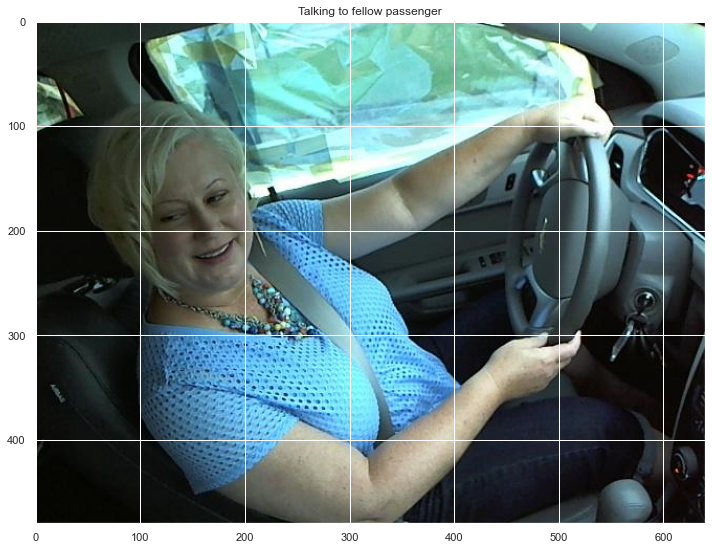

In [ ]:
plt.figure(figsize = (12, 20))
train_dir = 'C:/Users/Abhin/Downloads/state-farm-distracted-driver-detection/imgs/train/'
test_dir = 'C:/Users/Abhin/Downloads/state-farm-distracted-driver-detection/imgs/test/'

for directory in os.listdir(train_dir):
    
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(DIR + directory)):
            if i == 2:
                break
            else:
                #fig = plt.subplot(2, 2, image_count)
                #image_count += 1
                image = mpimg.imread(DIR + directory + '/' + file)
                plt.imshow(image)
                plt.title(category_dict[directory])

In [ ]:
print(X_train.shape,y_train.shape)

(19060, 224, 224, 3) (19060, 10)


In [ ]:
base_model  = tf.keras.applications.resnet.ResNet50(include_top = False,
                                                  weights = 'imagenet',
                                                  input_shape = (224,224,3))
base_model.summary()

94773248/94765736 [==============================] - 18s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_________________________

In [ ]:
x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)

output =tf.keras.layers.Dense(CLASSES,activation = tf.nn.softmax)(x)
model = tf.keras.models.Model(inputs=base_model.inputs, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
num_epochs = 50
def lr_schedule(epoch,lr):
    # Learning Rate Schedule

    lr = lr
    total_epochs = num_epochs

    check_1 = int(total_epochs * 0.9)
    check_2 = int(total_epochs * 0.8)
    check_3 = int(total_epochs * 0.6)
    check_4 = int(total_epochs * 0.4)

    if epoch > check_1:
        lr *= 1e-4
    elif epoch > check_2:
        lr *= 1e-3
    elif epoch > check_3:
        lr *= 1e-2
    elif epoch > check_4:
        lr *= 1e-1

    print("[+] Current Lr rate : {} ".format(lr))
    return lr
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [ ]:
history = model.fit(
      x = X_train,y=y_train,
      validation_data=(X_valid,y_valid),
      steps_per_epoch=16,
      batch_size = 8,
      epochs=num_epochs,
    
    callbacks = [lr_callback],
      verbose=1)

Epoch 1/50
[+] Current Lr rate : 9.999999747378752e-05 
16/16 [==============================] - 217s 14s/step - loss: 5.8530 - accuracy: 0.0734 - val_loss: 6.4441 - val_accuracy: 0.0939
Epoch 2/50
[+] Current Lr rate : 9.999999747378752e-05 
16/16 [==============================] - 200s 13s/step - loss: 6.8743 - accuracy: 0.1353 - val_loss: 7.2206 - val_accuracy: 0.0815
Epoch 3/50
[+] Current Lr rate : 9.999999747378752e-05 
16/16 [==============================] - 215s 14s/step - loss: 6.4661 - accuracy: 0.0876 - val_loss: 6.1488 - val_accuracy: 0.0874
Epoch 4/50
[+] Current Lr rate : 9.999999747378752e-05 
16/16 [==============================] - 208s 14s/step - loss: 6.3524 - accuracy: 0.1710 - val_loss: 6.7305 - val_accuracy: 0.0942
Epoch 5/50
[+] Current Lr rate : 9.999999747378752e-05 
16/16 [==============================] - 217s 14s/step - loss: 7.8994 - accuracy: 0.0550 - val_loss: 9.3906 - val_accuracy: 0.0907
Epoch 6/50
[+] Current Lr rate : 9.999999747378752e-05 
16/16 [==

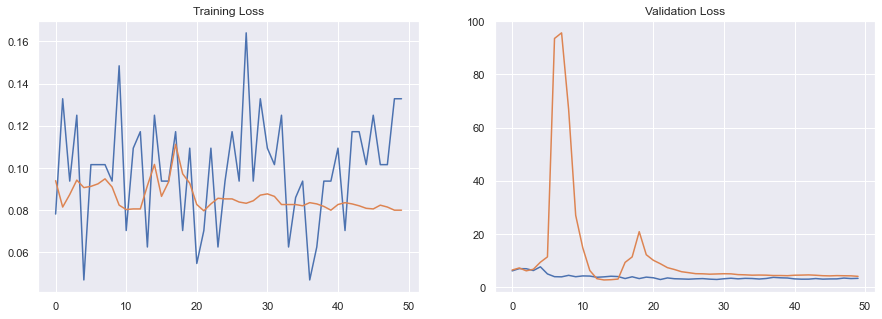

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])

In [ ]:
#Preparing data augmentation
'''Generate batches of tensor image data with real-time data augmentation.'''

train_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255,
                               height_shift_range=0.5,
                               width_shift_range = 0.5,
                               rotation_range=30,
                               validation_split = 0.2)

valid_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/ 255, validation_split = 0.2)

In [ ]:
'''Takes the dataframe and the path to a directory + generates batches of augmented/normalized data.'''
BATCHES = 50

train_loader = train_img_gen.flow_from_directory(train_dir, 
                                                 target_size = (IMG_SIZE, IMG_SIZE), 
                                                 batch_size = BATCHES,
                                                 shuffle=True,
                                                 class_mode='categorical', subset="training")


val_loader = valid_img_gen.flow_from_directory(train_dir, 
                                                   target_size = (IMG_SIZE, IMG_SIZE), 
                                                   batch_size = BATCHES,
                                                   shuffle=False,
                                                   class_mode='categorical', subset="validation")

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [ ]:
train_samples = 17943
valid_samples = 4481

In [ ]:
val_loader

In [ ]:
def plot_train_history(history):
    # Summarize history for accuracy
    plt.figure(figsize = (8, 5))
    #plt.xticks(np.arange(0, 10))
    #plt.yticks(np.arange(0, 100))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.figure(figsize = (8, 5))
    #plt.xticks(np.arange(0, 10))
    #plt.yticks(np.arange(0, 100))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower left')
    plt.show()

In [ ]:
def vgg_model(img_rows=img_size, img_cols=img_size, color_type=channel):
    # Remove fully connected layer and replace
    # with softmax for classifying 10 classes
    vgg16_model_2 = VGG16(weights="imagenet", include_top=False)

    # Freeze all layers of the pre-trained model
    for layer in vgg16_model_2.layers:
        layer.trainable = False
        
    x = vgg16_model_2.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(n_classes, activation = 'softmax')(x)

    model = Model(inputs = vgg16_model_2.input, outputs = predictions)
    
    return model

In [ ]:
model_vgg16_2 = vgg_model(img_rows=img_size, img_cols=img_size)

model_vgg16_2.summary()

model_vgg16_2.compile(loss='categorical_crossentropy',
                         optimizer='rmsprop',
                         metrics=['accuracy'])

Loading network...
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='saved_models/weights_best_vgg16_model2.hdf5', 
                               verbose=1, save_best_only=True)

In [ ]:
history = model_vgg16_2.fit_generator(train_loader,
                         steps_per_epoch = 17943/50, # (len(training_samples) / no_of_epochs)
                         epochs = epochs, 
                         callbacks=[early_stopping, checkpoint],
                         verbose = 1,
                         validation_data = val_loader,
                         validation_steps = 4481/50) # (len(validation_samples) / no_of_epochs)

c:\users\abhin\documents\surabhi\virtual-environment\venvassign\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
358/358 [==============================] - 2280s 6s/step - loss: 2.2905 - accuracy: 0.1584 - val_loss: 1.9008 - val_accuracy: 0.2778

Epoch 00001: val_loss improved from inf to 1.90078, saving model to saved_models\weights_best_vgg16_model2.hdf5
Epoch 2/50
358/358 [==============================] - 1985s 6s/step - loss: 1.9154 - accuracy: 0.3253 - val_loss: 1.4565 - val_accuracy: 0.4954

Epoch 00002: val_loss improved from 1.90078 to 1.45651, saving model to saved_models\weights_best_vgg16_model2.hdf5
Epoch 3/50
358/358 [==============================] - 2076s 6s/step - loss: 1.7156 - accuracy: 0.4036 - val_loss: 1.3367 - val_accuracy: 0.5070

Epoch 00003: val_loss improved from 1.45651 to 1.33672, saving model to saved_models\weights_best_vgg16_model2.hdf5
Epoch 4/50
358/358 [==============================] - 2044s 6s/step - loss: 1.5843 - accuracy: 0.4552 - val_loss: 1.3186 - val_accuracy: 0.4894

Epoch 00004: val_loss improved from 1.33672 to 1.31857, saving model to save

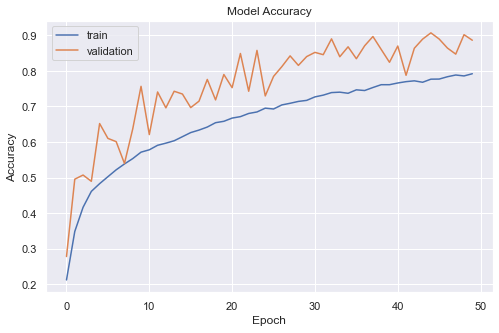

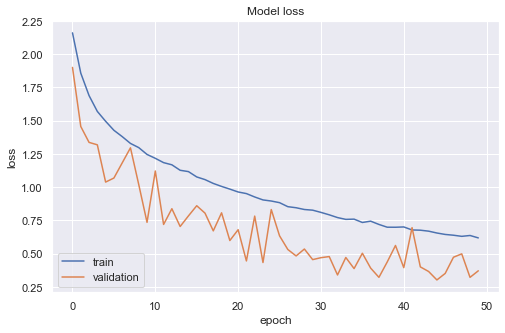

In [ ]:
plot_train_history(history)

1/1 [==============================] - 0s 63ms/step
[[6.3625043e-07 8.8955430e-06 3.6538601e-01 2.6687712e-05 2.5237579e-05
  5.6066539e-02 2.1871780e-03 1.3008258e-06 5.7476008e-01 1.5374629e-03]]
Y Prediction: 8
Predicted as: Looking Away


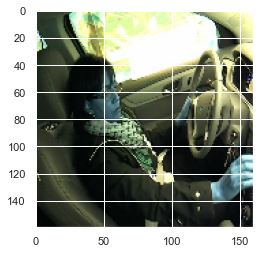

1/1 [==============================] - 0s 67ms/step
[[9.9099839e-01 1.1838835e-03 8.4666923e-10 4.2176070e-03 4.6756849e-08
  3.2288532e-03 1.0798303e-07 1.3320112e-06 3.6835120e-04 1.5455344e-06]]
Y Prediction: 0
Predicted as: Safe driving


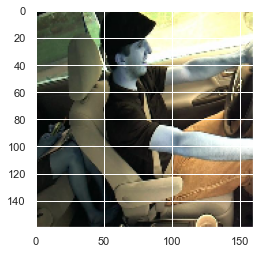

1/1 [==============================] - 0s 69ms/step
[[1.4592721e-02 2.9322423e-02 8.3298470e-09 6.4214021e-08 2.7210381e-09
  7.4553323e-06 2.0221465e-03 2.1330593e-06 5.4651517e-01 4.0753782e-01]]
Y Prediction: 8
Predicted as: Looking Away


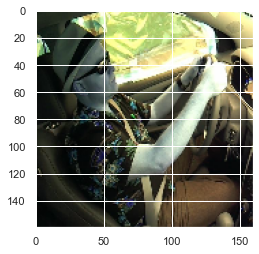

1/1 [==============================] - 0s 66ms/step
[[1.77880244e-15 1.11270326e-10 9.33039248e-01 3.28123921e-17
  2.81799161e-13 1.29555614e-13 3.94185081e-05 1.17261947e-11
  6.69213831e-02 3.78328080e-09]]
Y Prediction: 2
Predicted as: Talking on the phone - right side


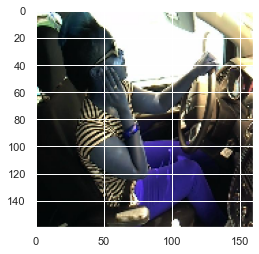

1/1 [==============================] - 0s 64ms/step
[[1.20792638e-05 1.17883974e-06 4.68754661e-06 9.91881192e-01
  8.08685180e-03 1.05883344e-10 1.38039532e-05 6.21779711e-11
  1.48960680e-07 1.04675713e-10]]
Y Prediction: 3
Predicted as: Texting on the phone - left side


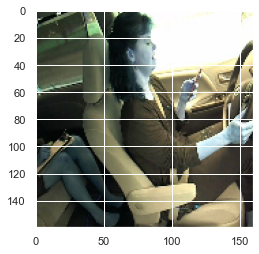

1/1 [==============================] - 0s 83ms/step
[[3.5985465e-07 1.1944908e-01 8.0361069e-06 1.4093833e-03 1.4119364e-07
  1.3272951e-03 7.8379299e-04 1.0381402e-05 8.7701130e-01 1.9880717e-07]]
Y Prediction: 8
Predicted as: Looking Away


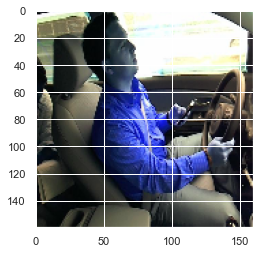

1/1 [==============================] - 0s 72ms/step
[[6.3817753e-14 7.4047796e-11 9.0202558e-01 8.4366431e-11 1.6248005e-07
  5.9474309e-12 3.4409121e-04 7.3759470e-09 9.7630113e-02 1.0477432e-09]]
Y Prediction: 2
Predicted as: Talking on the phone - right side


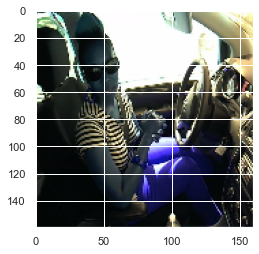

1/1 [==============================] - 0s 66ms/step
[[1.0607978e-02 5.6658632e-01 3.5241155e-05 4.0304366e-01 4.2947909e-06
  2.7566334e-06 1.9621458e-02 3.5251180e-10 8.6619388e-05 1.1702465e-05]]
Y Prediction: 1
Predicted as: Texting on the phone - right side


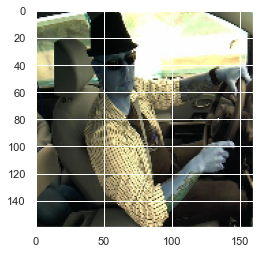

1/1 [==============================] - 0s 63ms/step
[[8.0095615e-06 5.1816620e-05 3.5991180e-01 2.6522695e-05 2.1009303e-03
  1.5744088e-05 3.6283720e-02 7.4857143e-12 6.0157084e-01 3.0589217e-05]]
Y Prediction: 8
Predicted as: Looking Away


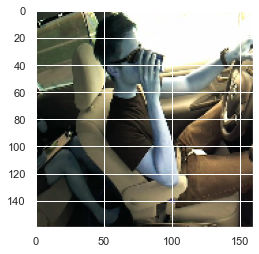

1/1 [==============================] - 0s 62ms/step
[[1.0473067e-03 9.6925652e-01 9.9668442e-04 2.2794010e-02 2.2025381e-05
  3.1428129e-07 3.6425036e-03 2.1271412e-04 1.9967584e-03 3.1103868e-05]]
Y Prediction: 1
Predicted as: Texting on the phone - right side


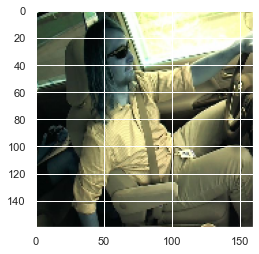

In [ ]:
def prediction():
    for i in np.arange(10):
        im =  cv2.resize(cv2.cvtColor((test_data[i], cv2.COLOR_BGR2RGB), (img_size,img_size)).astype(np.float32) / 255.0
        im = np.expand_dims(im, axis =0)

        img_display = cv2.resize(test_data[i],(img_size,img_size))
        plt.imshow(img_display, cmap='gray')

        y_preds = model_vgg16_2.predict(im, batch_size=batch_size, verbose=1)
        print(y_preds)
        y_prediction = np.argmax(y_preds)
        print('Y Prediction: {}'.format(y_prediction))
        print('Predicted as: {}'.format(category_dict.get('c{}'.format(y_prediction))))

        plt.show()
prediction()

# Testing on random image

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from tensorflow import keras
from keras.models import model_from_json

# load json and create model
json_file = open('/content/gdrive/MyDrive/258_Final_Project/VGG Model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/gdrive/MyDrive/258_Final_Project/VGG Model/weights_best_vgg16_model2.hdf5")
print("Loaded model from disk")

Loaded model from disk


1/1 [==============================] - 1s 654ms/step
[[2.4121579e-08 6.4914484e-11 1.9008290e-08 2.4022531e-09 3.0313447e-09
  7.1173326e-06 1.2194606e-07 3.1126125e-03 2.0081467e-04 9.9667931e-01]]
Y Prediction: 9
Predicted as: Talking to fellow passenger


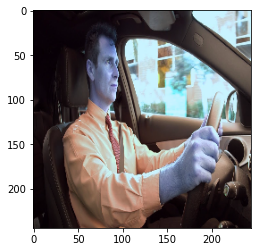

In [ ]:
image = cv2.imread("/content/gdrive/MyDrive/258_Final_Project/VGG Model/safe.jpg")
im = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (244,244)).astype(np.float32) / 255.0
im = np.expand_dims(im, axis =0)

img_display = cv2.resize(image,(244,244))
plt.imshow(img_display, cmap='gray')

y_preds = loaded_model.predict(im, batch_size=50, verbose=1)
print(y_preds)
y_prediction = np.argmax(y_preds)
print('Y Prediction: {}'.format(y_prediction))
print('Predicted as: {}'.format(category_dict.get('c{}'.format(y_prediction))))

plt.show()